In [32]:
import warnings
warnings.filterwarnings(action='ignore') 

import datetime
import pandas as pd
import numpy as np
import csv
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans    ##  K-means 임포트
from sklearn.metrics import silhouette_score
import scipy as sp
import statsmodels.formula.api as smf
from dateutil.relativedelta import relativedelta
plt.rc('font',family='D2CodingLigature Nerd Font')
# plt.rcParams['axes.unicode_minus']=False  # '- 표시

In [2]:
retail_df = pd.read_excel('../../data/Online_Retail.xlsx')
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 데이터 준비 및 탐색

In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail_df = retail_df[retail_df['Quantity'] > 0] 
retail_df.count()

InvoiceNo      531285
StockCode      531285
Description    530693
Quantity       531285
InvoiceDate    531285
UnitPrice      531285
CustomerID     397924
Country        531285
dtype: int64

In [5]:
retail_df = retail_df[retail_df['UnitPrice'] > 0] 
retail_df.count()

InvoiceNo      530104
StockCode      530104
Description    530104
Quantity       530104
InvoiceDate    530104
UnitPrice      530104
CustomerID     397884
Country        530104
dtype: int64

In [6]:
retail_df = retail_df[retail_df['CustomerID'].notnull()] 
retail_df.count()

InvoiceNo      397884
StockCode      397884
Description    397884
Quantity       397884
InvoiceDate    397884
UnitPrice      397884
CustomerID     397884
Country        397884
dtype: int64

In [7]:
# 중복 레코드 제거

retail_df.drop_duplicates(inplace=True)
print(retail_df.shape)

(392692, 8)


In [8]:
pd.DataFrame({'Product': len(retail_df['StockCode'].unique()),  
              'Transaction':len(retail_df['InvoiceNo'].unique()),
               'Customer':len(retail_df['CustomerID'].unique())}, index = ['counts']) 

,Product,Transaction,Customer
counts,3665,18532,4338


In [9]:
retail_df['Country'].value_counts()

Country
United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [10]:
# 주문금액(SaleAmount) 컬럼 추가 후 금액 계산

retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [12]:
# 'CustomerID' 자료형을 정수형으로 변환

retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   SaleAmount   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [13]:
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00


In [14]:
customer_df = retail_df.groupby('CustomerID').agg({'InvoiceNo':'count', 'SaleAmount':'sum', 'InvoiceDate':'max'})
customer_df

,InvoiceNo,SaleAmount,InvoiceDate
CustomerID,,,
12346,1,77183.60,2011-01-18 10:01:00
12347,182,4310.00,2011-12-07 15:52:00
12348,31,1797.24,2011-09-25 13:13:00
12349,73,1757.55,2011-11-21 09:51:00
12350,17,334.40,2011-02-02 16:01:00
...,...,...,...
18280,10,180.60,2011-03-07 09:52:00
18281,7,80.82,2011-06-12 10:53:00
18282,12,178.05,2011-12-02 11:43:00


In [15]:
customer_df = customer_df.reset_index()
customer_df.head(2)

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.6,2011-01-18 10:01:00
1,12347,182,4310.0,2011-12-07 15:52:00


In [16]:
# 컬럼이름 바꾸기

customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'})
customer_df.head(3)

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00


In [17]:
# 경과된 날을 계산(기준일 : 2011.12.10)

customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays']
customer_df.head(3)

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00


In [18]:
# 시간을 올림으로 처리

customer_df['ElapsedDays'] = customer_df['ElapsedDays'].dt.days + 1
customer_df.head(3)

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76


## 분포확인

([<matplotlib.axis.XTick at 0x73b7d2b112e0>,
 [Text(1, 0, 'Freq'), Text(2, 0, 'SaleAmount'), Text(3, 0, 'ElapsedDays')])

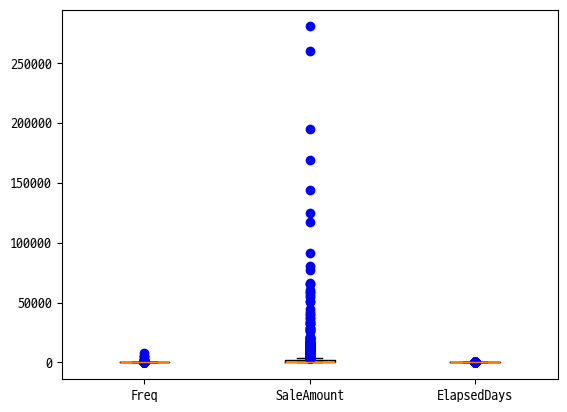

In [19]:
plt.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym='bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount','ElapsedDays' ])

#### 데이터의 치우침을 줄이기 위한 작업 : 로그 함수로 분포 조정

In [20]:
customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head(3)

## 데이터 분포를 정규화하고, 모델의 성능을 높이는 데 자주 사용

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805


([<matplotlib.axis.XTick at 0x73b7d263bb00>,
 [Text(1, 0, 'Freq_log'),
  Text(2, 0, 'SaleAmount_log'),
  Text(3, 0, 'ElapsedDays_log')])

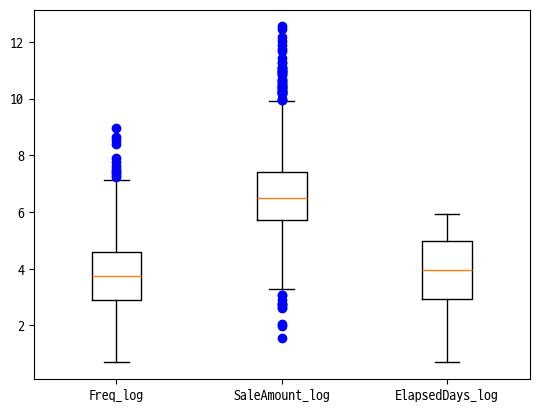

In [21]:
plt.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']], sym='bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log','ElapsedDays_log' ])

In [22]:
x_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values
x_features

array([[ 0.69314718, 11.25395523,  5.78996017],
       [ 5.20948615,  8.36892517,  1.38629436],
       [ 3.4657359 ,  7.49456369,  4.34380542],
       ...,
       [ 2.56494936,  5.1876651 ,  2.19722458],
       [ 6.58202514,  7.62390095,  1.60943791],
       [ 4.26267988,  7.51658563,  3.78418963]], shape=(4338, 3))

In [23]:
x_features_scaled = StandardScaler().fit_transform(x_features)
x_features_scaled

array([[-2.43820181,  3.7077163 ,  1.47888429],
       [ 1.18898578,  1.41490344, -1.89064214],
       [-0.21146474,  0.72002428,  0.37233877],
       ...,
       [-0.9349095 , -1.11333158, -1.27014755],
       [ 2.29130702,  0.82281217, -1.71990073],
       [ 0.42858139,  0.73752572, -0.05585907]], shape=(4338, 3))

## 최적의 K찾기 _ 엘보우방법

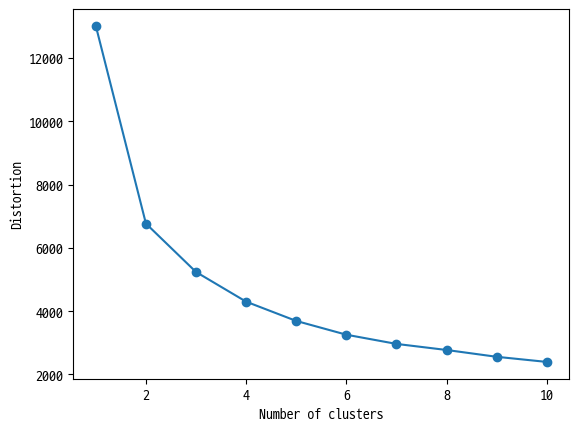

In [24]:
d = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=0)  # 모델 생성
    kmeans_i.fit(x_features_scaled)   # 모델 실행
    d.append(kmeans_i.inertia_) # 클러스터 내 응집도, 중심점에서 데이터까지의 거리 제곱합, 값이 작을수록 데이터에 잘 맞는 분석

plt.plot(range(1,11), d, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [25]:
## 클러스터의 개수를 4로 설정하여 모델구축
kmeans = KMeans(n_clusters=4, random_state=0) 

## 모델 실행 
Y_labels = kmeans.fit(x_features_scaled)

In [26]:
customer_df['ClusterLabel'] = kmeans.labels_
customer_df.head(3)

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,0
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,0


In [31]:
## 실루엣계수 
## ==> 데이터가 자기 군집에는 얼마나 잘 속해 있는지, 또한 다른 군집과는 얼마나 잘 떨어져 있는지를 나타냄
## 0.5 이상 : 군집구조 좋음
## 0.3~0.5 : 나쁘지 않음
## 0.3 미만 : 불분명
## 음수 : 잘못된 군집

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(x_features_scaled)

Y_labels = kmeans.labels_
score = silhouette_score(x_features_scaled, Y_labels)
score

0.3066722995226066

In [40]:
scores = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x_features_scaled)
    Y_labels = kmeans.labels_
    score = silhouette_score(x_features_scaled, Y_labels)
    scores.append(score)
    
scores

[0.3995380203021941,
 0.30264004884741935,
 0.3066722995226066,
 0.27694302566432716,
 0.2767682347086801,
 0.2668263702921398,
 0.25994606718229774,
 0.2603381418023211,
 0.26846408005964706]

<Axes: xlabel='ClusterLabel', ylabel='ElapsedDays'>

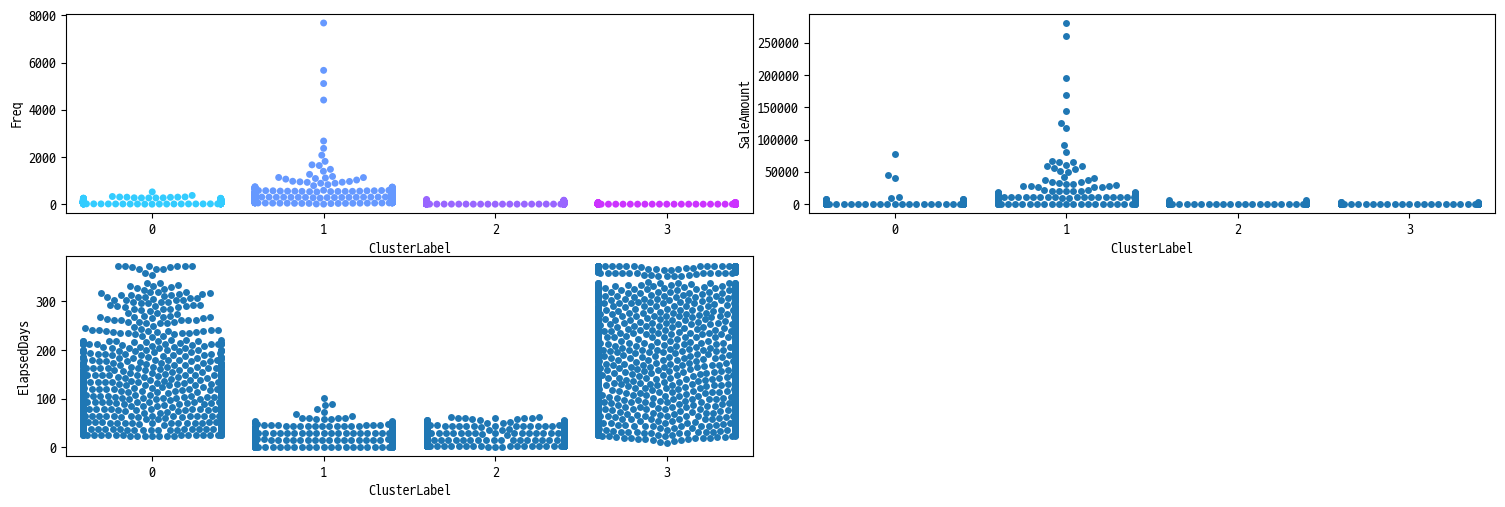

In [27]:
fig = plt.figure(figsize=(15, 5))   
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

plt.tight_layout()

sns.swarmplot(x="ClusterLabel",   y="Freq",   data=customer_df, ax=ax1, palette='cool')  
sns.swarmplot(x="ClusterLabel",   y="SaleAmount",  data=customer_df,   ax=ax2)   
sns.swarmplot(x="ClusterLabel",   y="ElapsedDays",  data=customer_df,   ax=ax3) 

In [28]:
customer_df.groupby("ClusterLabel").count()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
ClusterLabel,,,,,,,
0,1167,1167,1167,1167,1167,1167,1167
1,900,900,900,900,900,900,900
2,931,931,931,931,931,931,931
3,1340,1340,1340,1340,1340,1340,1340


In [29]:
customer_df.groupby("ClusterLabel").mean()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
ClusterLabel,,,,,,,
0,15219.377892,74.443873,1453.809907,106.652956,4.129035,6.983863,4.463390
1,15178.794444,275.008889,6901.516111,14.833333,5.283206,8.207821,2.411961
2,15385.004296,41.978518,643.460173,20.473684,3.525348,6.234333,2.842557
3,15393.882090,14.347761,283.721501,184.191791,2.478357,5.402845,5.004879


<Axes: xlabel='ClusterLabel', ylabel='ElapsedDays'>

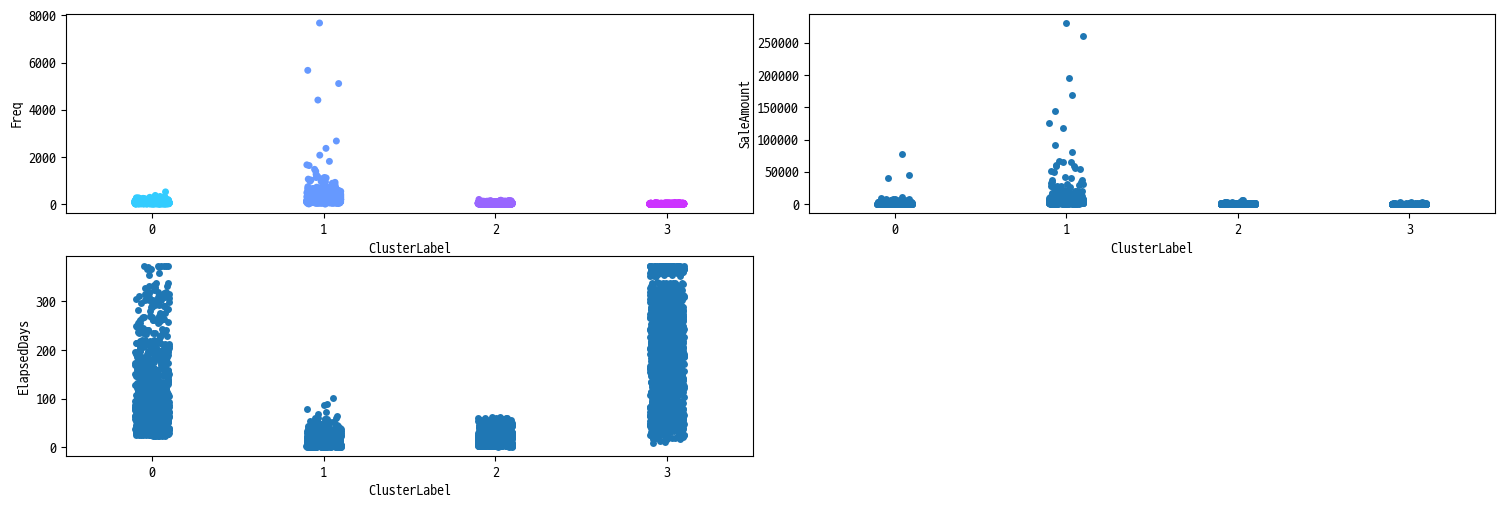

In [30]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

plt.tight_layout()

sns.stripplot(x="ClusterLabel", y="Freq", data=customer_df, ax=ax1, palette='cool')
sns.stripplot(x="ClusterLabel", y="SaleAmount", data=customer_df, ax=ax2)
sns.stripplot(x="ClusterLabel", y="ElapsedDays", data=customer_df, ax=ax3)